### Finding a bound on a mixture of Gaussians

If we have n Gaussians, each scaled by a weight $w_i$. We assume for now that each dimension has equal variance and there is no covariance (i.e. the covariance matrix, $C$, is a diagonal, on which all the values are $l^2$, where $l$ is the lengthscale.

We approach this by considering checking a grid of locations within which we know a priori that the maximum must lie (or possibly we're only interested in maxima within the grid). If we consider a single location $x$ on the grid, near the global maximum $x_*$. How much larger than $f(x)$ can $f(x_*)$ be?

We can find a simple bound for this, by considering the case in which all the data points (in which $w>0$) lie at the same location. So an upper bound for the peak is,

$S = \sum_{i=1}^n (w_i)$

where we assume the maximum of the Gaussians are $w_i$.

Therefore, if we test a point within distance $d$ from the peak (evalutating the Gaussian $G(d|0,C)$) we will have a result that is within 

$S \left[1 - G(d|0,C)\right]$ 

of the peak.

So if we test a grid, in which each grid point is within $2d$ of another grid point, we can say that the maximum is no greater than the greatest grid point plus the above difference.

For a $d$ dimensional grid, the largest distance between a square grid spaced $g$ apart is $g\sqrt{d}$. For example a 3d grid, spaced 2 apart has a diagonal distance of 3.464. Thus the largest distance ($p$) we should consider is half that; 1.732.

### PCA

We can find a bound for higher dimensions by reducing the dimensionality. Initially this only works if the weights are positive.

The distance between points in the PCA low dimensional space are always less than or equal to the distances in the full domain. Thus it's fairly straightforward to apply PCA and then compute (over the now slightly larger domain) the bound.

#### Handling Negative Weights

Note however that as the negative values could be moved much closer to the global maximum, thus reducing it wrongly, we can't use this method with negative weights. Example situation:

        2d domain                X <-- +1 training point
                                 | 
                                 | 
                                 |
                                 |
         ------------------------------------------- <-- 1d manifold
                                |
                                O <-- -1 training point


The maximum in the original domain is +1.

The maximum in the 1d domain, due to the proximity of the -1 training point to the +1 training point is only, for example, 0.2. 

For large lengthscales there might be mileage in just scaling the negative values by the greatest reduction a point could experience...

I'm not sure how to do this yet...ignoring negatives seems like a really bad idea though.

Install with:

        git clone https://github.com/lionfish0/boundmixofgaussians.git
        cd boundmixofgaussians
        pip install -e .

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from boundmixofgaussians import zeromean_gaussian, findbound, PCA, findbound_lowdim

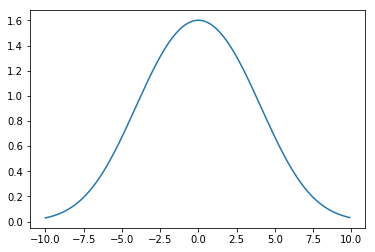

In [2]:
X = np.arange(-10,10,0.1)[:,None]
plt.plot(X[:,0],zeromean_gaussian(X-2,3)+zeromean_gaussian(X+2,3))

In [69]:
d = 6
n = 1000
X = np.random.rand(n,d)*10
W = np.abs(np.random.randn(n)) #scale of each
s = time.time()
b = findbound(X,W,ls=2,d=d,gridspacing=0.45,gridstart=np.array([0]*d),gridend=np.array([10]*d))
print(b)
print(time.time()-s)

Compacting to 3d manifold...
[121.01536653]
5.113094806671143


In [70]:
s = time.time()
b = findbound_lowdim(X,W,ls=2,d=d,gridspacing=1.5,gridstart=np.array([0]*d),gridend=np.array([10]*d))
print(b)
print(time.time()-s)

[282.80200118]
4.783750057220459


In [4]:
gridsize = 10
results = []
for gridspacing in [0.05,0.1,0.2,0.4,0.8,1.6,3.2]:
    b = findbound(X,W,ls=2,d=d,gridspacing=gridspacing,gridstart=[0],gridend=[10])
    results.append((gridspacing,b))

Text(0,0.5,'Upper Bound on maximum')

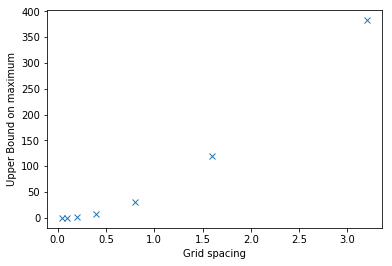

In [5]:
results = np.array(results)
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(results[:,0],results[:,1],'x')
plt.xlabel('Grid spacing')
plt.ylabel('Upper Bound on maximum')

In [6]:
#54 dimensions, 100 gaussians
d = 54
n = 100
X = np.random.rand(n,d)*10
W = np.random.randn(n) #scale of each
#make it binary
W[W<0] = -1
W[W>=0] = +1

In [7]:
lowd = 3
distancebetweengridpoints = 0.5
gridspacing = np.sqrt((distancebetweengridpoints**2)/lowd)
print(gridspacing)
lowdX,evals,evecs,means = PCA(X.copy(),lowd)
movedlowdX=lowdX-np.min(lowdX)  #move to be from zero
print("finding bound...")
b = findbound(movedlowdX,W,ls=2,d=lowd,gridspacing=gridspacing,gridstart=[np.min(movedlowdX)-gridspacing]*lowd,gridend=[np.max(movedlowdX)+gridspacing]*lowd,ignorenegatives=True)
b

0.28867513459481287
finding bound...


array([4.15400981])

In [8]:
#Demonstrates that the distance between the points in the lower dimensional space
#are always closer together.
from scipy.spatial.distance import pdist, squareform
assert np.all(squareform(pdist(X, 'euclidean'))-squareform(pdist(lowdX, 'euclidean'))>=0)

In [ ]:
X = np.random.rand(n,d)*10

In [12]:
lowdX, evals, evecs, means = PCA(X,2)

In [16]:
centre = np.ones([1,54])*0.5

In [17]:
(evecs.T @ centre.T).T

array([[-0.75026201, -0.3509858 ]])